In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import integrate, signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import subsample_lfp, remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

## Load subjects from file

In [10]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_EEG_subjects.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

## Load EEG_exp and gather LFP traces

In [11]:
overwrite_existing_files = False

before_event = 2. # s, look at 2 s pre-stim
after_event = 2. # s, look at 2 s post-stim

apply_mask = True
subsampling_factor = 2

In [12]:
for mouse_num, rec_folder in multi_sub_dict.items():
    print('{}'.format(mouse_num))
    exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    print(' {}'.format(exp_tag))
    
    probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
    if len(probe_list) == 0:
        print(' This experiment has no probe data, not making LFP files.\n')
        continue
    
    ## Set file names ##
    evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
    if not os.path.exists(evoked_folder):
        os.mkdir(evoked_folder)
    LFPinfo_filename = os.path.join(evoked_folder, 'evokedLFPinfo.json')
    LFPtime_filename = os.path.join(evoked_folder, 'evokedLFPtimestamps.npy')
    if os.path.exists(LFPinfo_filename) and not overwrite_existing_files:
        print(' LFP traces already exist, not overwriting files.\n')
        continue
    
    ## Load stim log ##
    stim_log = pd.read_csv(exp.stimulus_log_file)
    stim_log = stim_log.astype({'parameter': str})
    all_event_times = stim_log['onset'].values
    
    ## Get probe info ##
    print(' Getting probe info...')
    probe_LFP_data = {}
    probe_locs = np.ones((len(probe_list)), dtype=bool)
    for pbi, probei in enumerate(probe_list):
        ## Load probe_info.json ##
        with open(exp.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        if 'area_ch' in data.keys():
            probe_LFP_data[probei] = {}
            ## Get info ##
            npx_allch = np.array(data['channel']) # this is an array from 0 to 384
            surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
            air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
            allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
            ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
            ## Get all ch depths ##
            npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
            probe_LFP_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
            probe_LFP_data[probei]['all_chs'] = npx_allch
            ## Get saline chs for re-ref ##
            if air_ch - 10 > surface_ch:
                probe_LFP_data[probei]['saline_chs'] = np.arange(air_ch - 10, air_ch)
            else:
                probe_LFP_data[probei]['saline_chs'] = np.arange(surface_ch + 1, air_ch)
            ## Save info ##
            probe_LFP_data[probei]['ch_areas'] = np.array(data['area_ch'])
            probe_LFP_data[probei]['pop_chs'] = {key: [] for key in list(areas_of_interest.keys())}
            probe_LFP_data[probei]['pop_ch_depths'] = {key: [] for key in list(areas_of_interest.keys())}
            for chind in npx_chs:
                parent_region = [
                    k for k in list(areas_of_interest.keys()) if probe_LFP_data[probei]['ch_areas'][chind] in areas_of_interest[k]
                ]
                if len(parent_region) == 1:
                    probe_LFP_data[probei]['pop_chs'][parent_region[0]].append(chind)
                    probe_LFP_data[probei]['pop_ch_depths'][parent_region[0]].append(probe_LFP_data[probei]['ch_depths'][chind])
        else:
            print('  {} does not have area assignments, not processing.'.format(probei))
            probe_locs[pbi] = False
            
    if probe_locs.any():
        pass
    else:
        print(' NO area assignments for any probes, not analyzing.\n')
        continue
            
    ## Extract LFP traces for each probe ##
    print(' Extracting traces...')
    pop_LFP = {key: [] for key in list(areas_of_interest.keys())}
    for probei, LFP_data in probe_LFP_data.items():
        ## Memmap LFP data ##
        start = time.time()
        lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
        lfp_mm = np.memmap(
            exp.ephys_params[probei]['lfp_continuous'], dtype='int16',
            shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')
        ## Mask artifact ##
        if apply_mask:
            mask_samples = int(0.002 * exp.ephys_params[probei]['lfp_sample_rate'])
            lfpdata = lfp_mm.copy()
            for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
                val = find_nearest_ind(lfp_ts, etime)
                lfpdata[val:val+mask_samples, :] = lfpdata[val:val-mask_samples:-1, :]
        else:
            lfpdata = lfp_mm.copy()
        del lfp_mm
        ## Downsample timestamps and data ##
        lfp_ts = lfp_ts[::subsampling_factor]
        new_samp_rate = exp.ephys_params[probei]['lfp_sample_rate'] / subsampling_factor
        lfpdata = subsample_lfp(lfpdata, LFP_data['all_chs'], subsampling_factor)
        ## Remove DC offset ##
        lfpdata = remove_lfp_offset(lfpdata, new_samp_rate, 0.1, 1)
        ## Subtract median of ACSF chs ##
        clean_lfp = np.zeros(lfpdata.shape, dtype='int16')
        saline_ref = np.median(lfpdata[:, LFP_data['saline_chs']], axis=1)
        for chi in LFP_data['all_chs']:
            tmp = lfpdata[:, chi] - saline_ref
            clean_lfp[:, chi] = tmp.astype('int16')
        del lfpdata
        ## Get evoked LFP traces ##
        lfp_event_traces, lfp_event_ts = get_evoked_traces(
            clean_lfp, lfp_ts, stim_log['onset'].values, before_event, after_event, new_samp_rate)
        lfp_event_traces = lfp_event_traces * exp.ephys_params[probei]['bit_volts']
        for region in LFP_data['pop_chs'].keys():
            pop_chs = LFP_data['pop_chs'][region]
            if len(pop_chs) == 0:
                continue
            pop_LFP[region].append(lfp_event_traces[:, pop_chs, :])
        del lfp_ts
        del clean_lfp
        del lfp_event_traces
        end = time.time()
        print('  {} - time to pre-process and epoch: {:.2f} min'.format(probei, (end-start)/60))
        
    ## Reorganize data ##
    pop_ch_depths = {key: [] for key in list(areas_of_interest.keys())}
    pop_ch_areas = {key: [] for key in list(areas_of_interest.keys())}
    for probei in probe_LFP_data.keys():
        for region in probe_LFP_data[probei]['pop_ch_depths'].keys():
            pop_ch_depths[region].append(probe_LFP_data[probei]['pop_ch_depths'][region])
            pop_ch_areas[region].append(probe_LFP_data[probei]['ch_areas'][probe_LFP_data[probei]['pop_chs'][region]])
    
    ## Save the data ##
    print(' Saving traces...')
    LFPtraces_info = {}
    for region in pop_LFP.keys():
        LFP_filename = os.path.join(evoked_folder, region + '_evokedLFPtraces.npy')
        if len(pop_LFP[region]) == 0:
            print('  No chs were found for {}, not saving data.'.format(region))
            continue
        LFPtraces_info[region] = {}

        reg_ch_depths = np.concatenate(pop_ch_depths[region])
        reg_ch_areas = np.concatenate(pop_ch_areas[region])
        LFP_traces = np.concatenate(pop_LFP[region], axis=1)

        CH_DEPTH_SORT = np.argsort(reg_ch_depths)
        LFPtraces_info[region]['ch_depths'] = reg_ch_depths[CH_DEPTH_SORT].tolist()
        LFPtraces_info[region]['ch_areas'] = reg_ch_areas[CH_DEPTH_SORT].tolist()

        print('  Saving {}.'.format(LFP_filename))
        np.save(LFP_filename, LFP_traces[:, CH_DEPTH_SORT, :], allow_pickle=False)

    print('  Saving {}.'.format(LFPinfo_filename))
    with open(LFPinfo_filename, 'w') as outfile:
        json.dump(LFPtraces_info, outfile, indent = 4, separators = (',', ': '))
    print('  Saving {}.'.format(LFPtime_filename))
    np.save(LFPtime_filename, lfp_event_ts, allow_pickle=False)
    print('')

521885
Experiment type: electrical stimulation
SomnoSuite log file not found.
 estim1
 This experiment has no probe data, not making LFP files.

521886
Experiment type: electrical stimulation
SomnoSuite log file not found.
 estim1
 This experiment has no probe data, not making LFP files.

521887
Experiment type: electrical stimulation
SomnoSuite log file not found.
 estim1
 This experiment has no probe data, not making LFP files.

543393
Experiment type: electrical stimulation
SomnoSuite log file not found.
 estim1
 Getting probe info...
  probeB does not have area assignments, not processing.
 NO area assignments for any probes, not analyzing.

543394
Experiment type: electrical stimulation
SomnoSuite log file not found.
 estim1
 Getting probe info...
  probeB does not have area assignments, not processing.
 NO area assignments for any probes, not analyzing.

543395
Experiment type: electrical stimulation
SomnoSuite log file not found.
 estim1
 Getting probe info...
  probeB does not 

## Test on single subject

### Define data path

In [10]:
rec_folder = r'F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
estim_vis


In [11]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

#### Load stim table and speed signal

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
0,biphasic,30,313.21234,313.21274,0.0004,0,True,0.0,True
1,biphasic,10,317.12436,317.12476,0.0004,0,True,0.0,True
2,biphasic,10,321.22743,321.22783,0.0004,0,True,0.0,True
3,biphasic,50,325.47838,325.47878,0.0004,0,True,0.0,True
4,biphasic,50,329.56234,329.56274,0.0004,0,True,0.0,True


#### Load unit data

In [13]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeF']


In [14]:
probe_LFP_data = {}
for probei in probe_list:
    print(probei)
    probe_LFP_data[probei] = {}
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_LFP_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    probe_LFP_data[probei]['all_chs'] = npx_allch
    
    ## Get saline chs for re-ref ##
    if air_ch - 10 > surface_ch:
        probe_LFP_data[probei]['saline_chs'] = np.arange(air_ch - 10, air_ch)
    else:
        probe_LFP_data[probei]['saline_chs'] = np.arange(surface_ch + 1, air_ch)
    if 'area_ch' in data.keys():
        probe_LFP_data[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_LFP_data[probei]['pop_chs'] = {key: [] for key in list(areas_of_interest.keys())}
        probe_LFP_data[probei]['pop_ch_depths'] = {key: [] for key in list(areas_of_interest.keys())}
        for chind in npx_chs:
            parent_region = [
                k for k in list(areas_of_interest.keys()) if probe_LFP_data[probei]['ch_areas'][chind] in areas_of_interest[k]
            ]
            if len(parent_region) == 1:
                probe_LFP_data[probei]['pop_chs'][parent_region[0]].append(chind)
                probe_LFP_data[probei]['pop_ch_depths'][parent_region[0]].append(probe_LFP_data[probei]['ch_depths'][chind])

probeB
 surface channel: 370
probeF
 surface channel: 275


### Get evoked LFP

In [15]:
before_event = 2. # s, look at 2 s pre-stim
after_event = 2. # s, look at 2 s post-stim

apply_mask = True
subsampling_factor = 2

In [16]:
pop_LFP = {key: [] for key in list(areas_of_interest.keys())}
raw_traces = {}
for probei, LFP_data in probe_LFP_data.items():
    ## Memmap LFP data ##
    print(probei)
    start = time.time()
    lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
    lfp_mm = np.memmap(
        exp.ephys_params[probei]['lfp_continuous'], dtype='int16',
        shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')
    
    ## Mask artifact ##
    if apply_mask:
        mask_samples = int(0.002 * exp.ephys_params[probei]['lfp_sample_rate'])
        lfpdata = lfp_mm.copy()
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(lfp_ts, etime)
            lfpdata[val:val+mask_samples, :] = lfpdata[val:val-mask_samples:-1, :]
    else:
        lfpdata = lfp_mm.copy()
    del lfp_mm
    
    ## Downsample timestamps and data ##
    lfp_ts = lfp_ts[::subsampling_factor]
    new_samp_rate = exp.ephys_params[probei]['lfp_sample_rate'] / subsampling_factor
    lfpdata = subsample_lfp(lfpdata, LFP_data['all_chs'], subsampling_factor)
    
    ## Remove DC offset ##
    lfpdata = remove_lfp_offset(lfpdata, new_samp_rate, 0.1, 1)
    
    ## Subtract median of ACSF chs ##
    clean_lfp = np.zeros(lfpdata.shape, dtype='int16')
    saline_ref = np.median(lfpdata[:, LFP_data['saline_chs']], axis=1)
    for chi in LFP_data['all_chs']:
        tmp = lfpdata[:, chi] - saline_ref
        clean_lfp[:, chi] = tmp.astype('int16')
    del lfpdata
    
    ## Get evoked LFP traces ##
    lfp_event_traces, lfp_event_ts = get_evoked_traces(
        clean_lfp, lfp_ts, stim_log['onset'].values, before_event, after_event, new_samp_rate)
    lfp_event_traces = lfp_event_traces * exp.ephys_params[probei]['bit_volts']
    
    raw_traces[probei] = [lfp_event_ts, lfp_event_traces]
    for region in LFP_data['pop_chs'].keys():
        pop_chs = LFP_data['pop_chs'][region]
        if len(pop_chs) == 0:
            continue
        pop_LFP[region].append(lfp_event_traces[:, pop_chs, :])

    del lfp_ts
    del clean_lfp
    del lfp_event_traces
    del lfp_event_ts
    
    end = time.time()
    print(' Time to pre-process and epoch: {:.2f} min'.format((end-start)/60))

probeB
 Time to pre-process and epoch: 14.77 min
probeF
 Time to pre-process and epoch: 14.12 min


In [17]:
pop_ch_depths = {key: [] for key in list(areas_of_interest.keys())}
pop_ch_areas = {key: [] for key in list(areas_of_interest.keys())}
for probei in probe_LFP_data.keys():
    for region in probe_LFP_data[probei]['pop_ch_depths'].keys():
        pop_ch_depths[region].append(probe_LFP_data[probei]['pop_ch_depths'][region])
        pop_ch_areas[region].append(probe_LFP_data[probei]['ch_areas'][probe_LFP_data[probei]['pop_chs'][region]])

### Plot population LFP traces

<IPython.core.display.Javascript object>


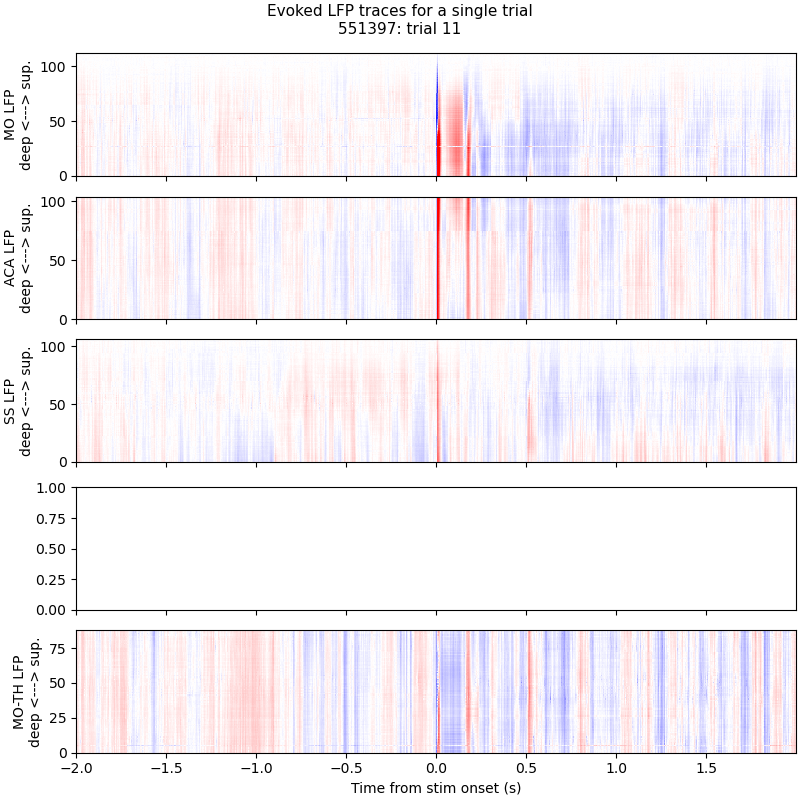

In [35]:
triali = 11
vlevel = 5000

fig, axs = plt.subplots(len(areas_of_interest), 1, figsize=(8,8), sharex=True, constrained_layout=True)
timex = raw_traces['probeB'][0]
for rowi, region in enumerate(areas_of_interest):
    if len(pop_LFP[region]) == 0:
        continue
        
    ## Plot LFP ##
    LFPtraces = np.concatenate(pop_LFP[region], axis=1)
    ch_depth_sort = np.squeeze(np.argsort(np.concatenate(pop_ch_depths[region], axis=0)))[::-1]
    axs[rowi].imshow(
        LFPtraces[:, ch_depth_sort, triali].T, cmap='bwr', interpolation='none', aspect='auto', origin='lower',
        vmin=-vlevel, vmax=vlevel, extent=[timex[0], timex[-1], 0, ch_depth_sort.shape[0]]
    )
    
    axs[rowi].set_ylabel('{} LFP\ndeep <---> sup.'.format(region))
    
axs[rowi].set_xlabel('Time from stim onset (s)')    
plt.suptitle('Evoked LFP traces for a single trial\n{}: trial {:d}'.format(exp.mouse, triali), fontsize=11)
## Save ##
figname = 'allPOP_LFPtraces_{}_trial{:d}-resting.png'.format(exp.mouse, triali)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

## Save the data

In [56]:
LFPtraces_info = {}
for region in pop_LFP.keys():
    print(region)
    start = time.time()
    LFP_filename = os.path.join(exp.data_folder, region + '_evokedLFPtraces.npy')
    if len(pop_LFP[region]) == 0:
        print(' No chs were found for this region, not saving data.\n')
        continue
    LFPtraces_info[region] = {}
    
    reg_ch_depths = np.concatenate(pop_ch_depths[region])
    reg_ch_areas = np.concatenate(pop_ch_areas[region])
    LFP_traces = np.concatenate(pop_LFP[region], axis=1)
    
    CH_DEPTH_SORT = np.argsort(reg_ch_depths)
    LFPtraces_info[region]['ch_depths'] = reg_ch_depths[CH_DEPTH_SORT].tolist()
    LFPtraces_info[region]['ch_areas'] = reg_ch_areas[CH_DEPTH_SORT].tolist()
    
    print(' Saving {}.'.format(LFP_filename))
#     np.save(LFP_filename, LFP_traces[:, CH_DEPTH_SORT, :], allow_pickle=False)
    end = time.time()
    print(' Time to save: {:.2f} s'.format(end-start))
    print('')
    
LFPinfo_filename = os.path.join(exp.data_folder, 'evokedLFPinfo.json')
with open(LFPinfo_filename, 'w') as outfile:
    json.dump(LFPtraces_info, outfile, indent = 4, separators = (',', ': '))
    
LFPtime_filename = os.path.join(exp.data_folder, 'evokedLFPtimestamps.npy')
np.save(LFPtime_filename, timex, allow_pickle=False)

MO
 Saving F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1\MO_evokedLFPtraces.npy.
 Time to save: 6.47 s

ACA
 Saving F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1\ACA_evokedLFPtraces.npy.
 Time to save: 6.01 s

SS
 Saving F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1\SS_evokedLFPtraces.npy.
 Time to save: 5.98 s

VIS
 No chs were found for this region, not saving data.

MO-TH
 Saving F:\EEG_exp\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1\MO-TH_evokedLFPtraces.npy.
 Time to save: 5.13 s

